# Пример использования IterativeImputer для замены пропусков



Документация - https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html  

Пример - https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/

**Подключение библиотек и скриптов**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_rows', 50)

### Загрузка датасета

In [3]:
TRAIN_DATASET_PATH = '../../Kurs_project_task/train.csv'
TEST_DATASET_PATH = '../../Kurs_project_task/test.csv'

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0000,47.9816,29.4428,6.0000,7,9.0000,1969,0.0890,B,B,33,7976,5,nan,0,11,B,"184,966.9307"
15053,41,3.0000,65.6836,40.0495,8.0000,7,9.0000,1978,0.0001,B,B,46,10309,1,240.0000,1,16,B,"300,009.4501"
4765,53,2.0000,44.9480,29.1976,0.0000,8,12.0000,1968,0.0496,B,B,34,7759,0,229.0000,1,3,B,"220,925.9085"
5809,58,2.0000,53.3530,52.7315,9.0000,8,17.0000,1977,0.4379,B,B,23,5735,3,"1,084.0000",0,5,B,"175,616.2272"
10783,99,1.0000,39.6492,23.7762,7.0000,11,12.0000,1976,0.0123,B,B,35,5776,1,"2,078.0000",2,4,B,"150,226.5316"


**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [5]:
train.shape

(10000, 19)

### Приведение типов

In [6]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

train[feature_bin_names] = train[feature_bin_names].replace({'A':0, 'B':1})

### Обработка пропусков

In [7]:
train.isna().sum()[train.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

**Базовый вариант** - обучим модель на данных без признаков с пропусками. Для предсказания используем GradientBoostingRegressor.

In [8]:
feature_names = train.drop(['LifeSquare', 'Healthcare_1', 'DistrictId', 'Price'], axis=1).columns
target_name = ['Price']

X = train[feature_names]
y = train[target_name]

In [9]:
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    n_iter_no_change=10,
    max_depth=8,
    max_features=6,
    random_state=42)

In [10]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(gb_model, X, y, scoring='r2', cv=cv)
print('R2: %.4f' % scores.mean())

R2: 0.7436


**1 вариант** - используем IterativeImputer() по умолчанию

Каждая переменная с пропусками представляется как функция от всех остальных переменных. Ее пропуски заменяются рассчитанными по этой функции значениями.

In [11]:
feature_names = train.drop(['DistrictId', 'Price'], axis=1).columns
X = train[feature_names]
X.isna().sum()[X.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

In [12]:
imputer = IterativeImputer()

X_imp = imputer.fit_transform(X)
scores = cross_val_score(gb_model, X_imp, y, scoring='r2', cv=cv)
print('R2: %.4f' % scores.mean())

R2: 0.7454


Метрика немного выросла.

**2 вариант** - подберем порядок замены пропусков

In [13]:
X = train[feature_names]
results = list()
strategies = ['ascending', 'descending', 'roman', 'arabic', 'random']
for s in strategies:
    imputer = IterativeImputer(imputation_order=s)
    X_imp = imputer.fit_transform(X)
    scores = cross_val_score(gb_model, X_imp, y, scoring='r2', cv=cv)
    results.append(scores)
    print('R2: %.4f - %s' % (scores.mean(), s))


R2: 0.7454 - ascending
R2: 0.7463 - descending
R2: 0.7454 - roman
R2: 0.7463 - arabic
R2: 0.7454 - random


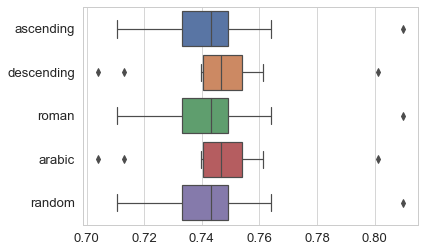

In [14]:
sns.boxplot(x=results, y=strategies);

Получили два варианта. Это логично, у нас всего два признака с пропущенными значениями. Лучше заполнять сначала Healthcare_1, а потом LifeSquare. Но это если использовать IterativeImputer с дефолтными настройками.

**3 вариант** - проверим разные модели для предсказания пропущенных значений:

- BayesianRidge
- DecisionTreeRegressor
- ExtraTreesRegressor
- KNeighborsRegressor





In [15]:
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

In [16]:
estimators = [
    BayesianRidge(normalize=True),
    DecisionTreeRegressor(random_state=42),
    ExtraTreesRegressor(random_state=42),
    KNeighborsRegressor()
]
results = list()
names = list()
for impute_estimator in estimators:
    imputer = IterativeImputer(random_state=42, 
                               estimator=impute_estimator, 
                               imputation_order='descending')
    X_imp = imputer.fit_transform(X)
    scores = cross_val_score(gb_model, X_imp, y, scoring='r2', cv=cv)
    results.append(scores)
    name = impute_estimator.__class__.__name__
    names.append(name)
    print('R2: %.4f - %s' % (scores.mean(), name))


R2: 0.7464 - BayesianRidge
R2: 0.7455 - DecisionTreeRegressor
R2: 0.7478 - ExtraTreesRegressor
R2: 0.7503 - KNeighborsRegressor


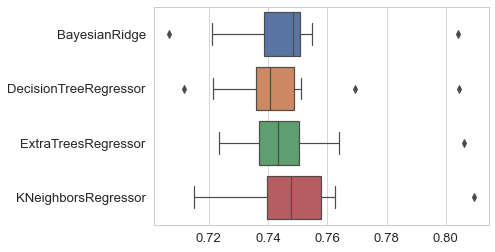

In [17]:
sns.boxplot(x=results, y=names);

Видно, что модель KNeighborsRegressor - лучший вариант при замене пропусков (по средним значениям), если imputation_order='descending' и max_iter=10.

### Настройка параметров

Подберем по сетке лучшую модель, порядок заполнения и параметр max_iter. Будем работать с отложенной выборкой.

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((7500, 17), (2500, 17), (7500, 1), (2500, 1))

In [19]:
X_train.isna().sum()[X_train.isna().sum() != 0]

LifeSquare      1594
Healthcare_1    3614
dtype: int64

In [20]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

pipeline = Pipeline(steps=[('imputer', IterativeImputer(random_state=42)), 
                           ('model', gb_model)])

params = {
    'imputer__estimator' : estimators,
    'imputer__imputation_order' : ['ascending', 'descending'],
    'imputer__max_iter' : np.arange(1, 5)
}

grid = GridSearchCV(pipeline, params, cv=cv, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)
print('R2 train: %.4f' % grid.best_score_)
print('R2 valid: %.4f' % grid.score(X_valid, y_valid))
print(grid.best_params_)

R2 train: 0.7294
R2 valid: 0.7295
{'imputer__estimator': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform'), 'imputer__imputation_order': 'descending', 'imputer__max_iter': 1}


Лучше всего для заполнения пропусков подходит модель KNeighborsRegressor. Определим для нее оптимальный параметр n_neighbors.

In [21]:
results = list()
for n in np.arange(3, 21):
    pipeline = Pipeline(steps=[('imputer', IterativeImputer(estimator=KNeighborsRegressor(
                                                                        n_neighbors=n),
                                                          imputation_order='descending',
                                                          max_iter=1, 
                                                          random_state=42)), 
                               ('model', gb_model)])
    pipeline.fit(X_train, y_train)
    y_hat = pipeline.predict(X_valid)
    results.append(r2_score(y_valid, y_hat))
    
res = pd.DataFrame(results, index=list(range(3, 21)))
res = res.T.stack().reset_index(1)
res.columns = ['n_neighbors', 'score']

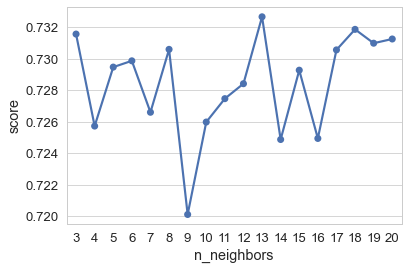

In [22]:
sns.pointplot(x='n_neighbors', y='score', data=res, join=True, estimator=np.mean);

Таким образом, следующий пайплайн можно использовать для замены пропусков и предсказания цен на квартиры. А можно не заморачиваться и выкинуть эти признаки (R2=0.7436)

In [27]:
pipeline = Pipeline(steps=[('imputer', IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=13),
                                                          imputation_order='descending',
                                                          max_iter=1, 
                                                          random_state=42)), 
                            ('model', gb_model)])
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_valid)
print('R2: %.4f' % r2_score(y_valid, y_hat))

R2: 0.7327


Что еще можно проверить?

- попробовать заполнить пропуски только в одном признаке.
- использовать IterativeImputer с другими оценщиками.